# T028 · Kinase similarity: Compare different perspectives

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will compare different perspectives on kinase similarity, which were discussed in detail in previous notebooks:

* **Talktorial T024**: Kinase pocket sequences (KLIFS pocket sequences)
* **Talktorial T025**: Kinase pocket structures (KiSSim fingerprint based on KLIFS pocket residues)
* **Talktorial T026**: Kinase-ligand interaction profiles (KLIFS IFPs based on KLIFS pocket residues)
* **Talktorial T027**: Ligand profiles

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: XXX

### Contents in *Practical*

* Retrieve and preprocess data
* Show kinase coverage
* Compare kinases
* Visualize similarity as kinase matrix
* Visualize similarity as phylogenetic tree

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Kinase similarity descriptor: XXX

## Theory

### Kinase dataset

We will use nine kinases from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629), which aimed to understand kinase similarities within different combinations of kinase on- and off-targets (also called anti-targets):

> We aggregated the investigated kinases in “profiles”. Profile 1 combined **EGFR** and **ErbB2** as targets and **BRAF** as a (general) anti-target. Out of similar considerations, Profile 2 consisted of EGFR and **PI3K** as targets and BRAF as anti-target. This profile is expected to be more challenging as PI3K is an atypical kinase and thus less similar to EGFR than for example ErbB2 used in Profile 1. Profile 3, comprised of EGFR and **VEGFR2** as targets and BRAF as anti-target, was contrasted with the hit rate that we found with a standard docking against the single target VEGFR2 (Profile 4).
> To broaden the comparison and obtain an estimate for the promiscuity of each compound, the kinases **CDK2**, **LCK**, **MET** and **p38α** were included in the experimental assay panel and the structure-based bioinformatics comparison as commonly used anti-targets.

*Table 1:*
Kinases used in this notebook, taken from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629), with their synonyms, UniProt IDs, kinase groups, and full unabbreviated names.

| Kinase                     | Synonyms               | UniProt ID | Group    | Full kinase name                                 |
|----------------------------|------------------------|------------|----------|--------------------------------------------------|
| EGFR                       | ErbB1                  | P00533     | TK       | Epidermal growth factor receptor                 |
| ErbB2                      | Her2                   | P04626     | TK       | Erythroblastic leukemia viral oncogene homolog 2 |
| PI3K                       | PI3KCA, p110a          | P42336     | Atypical | Phosphatidylinositol-3-kinase                    |
| VEGFR2                     | KDR                    | P35968     | TK       | Vascular endothelial growth factor receptor 2    |
| BRAF                       | -                      | P15056     | TKL      | Rapidly accelerated fibrosarcoma isoform B       |
| CDK2                       | -                      | P24941     | CMGC     | Cyclic-dependent kinase 2                        |
| LCK                        | -                      | P06239     | TK       | Lymphocyte-specific protein tyrosine kinase      |
| MET                        | -                      | P08581     | TK       | Mesenchymal-epithelial transition factor         |
| p38a                       | MAPK14                 | Q16539     | CMGC     | p38 mitogen activated protein kinase α           |

### Kinase similarity descriptor: XXX

Describe the dataset describing kinase similarity and how we use it.

- XXX = KLIFS pocket sequence
- XXX = KiSSim fingerprint
- XXX = KLIFS IFP
- XXX = Ligand promiscuity: ChEMBL28, bioactivity

## Practical

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load kinase matrices

In [6]:
kinase_distance_matrix_paths = {
    # "sequence": HERE / "../T024_kinase_similarity_sequence/data/kinase_similarity_matrix_sequence.csv",
    "kissim": HERE / "../T025_kinase_similarity_kissim/data/kinase_distance_matrix_kissim.csv",
    "ifp": HERE / "../T026_kinase_similarity_ifp/data/kinase_distance_matrix_ifp.csv",
    # "ligand-profile": HERE / "../T027_kinase_similarity_ligand_profile/data/kinase_similarity_matrix_ligand_profile.csv"
}

In [7]:
kinase_distance_matrices = {}
for kinsim_perspective, path in kinase_distance_matrix_paths.items():
    kinase_distance_matrices[kinsim_perspective] = pd.read_csv(path, index_col=0).round(6)

In [8]:
kinase_distance_matrices

{'kissim':             BRAF       CDK2       EGFR      ErbB2        KDR        LCK  \
 BRAF    0.000000  17.156339  19.515299  21.382788  21.089165  21.582682   
 CDK2   17.156339   0.000000  18.146634  21.106349  19.880467  17.972925   
 EGFR   19.515299  18.146634   0.000000  16.391994  17.281650  16.467225   
 ErbB2  21.382788  21.106349  16.391994   0.000000  23.850592  23.880970   
 KDR    21.089165  19.880467  17.281650  23.850592   0.000000  19.254898   
 LCK    21.582682  17.972925  16.467225  23.880970  19.254898   0.000000   
 MET    20.297483  18.304288  17.498395  22.563236  20.430532  19.221161   
 p110a  37.610863  36.780071  36.046207  41.277474  41.104455  39.022018   
 p38a   21.731421  19.480656  22.127617  24.681708  20.262541  22.456693   
 
              MET      p110a       p38a  
 BRAF   20.297483  37.610863  21.731421  
 CDK2   18.304288  36.780071  19.480656  
 EGFR   17.498395  36.046207  22.127617  
 ErbB2  22.563236  41.277474  24.681708  
 KDR    20.430532 

### Visualize similarity for example perspective

In [9]:
kinase_distance_matrix = kinase_distance_matrices["ifp"]

#### Visualize kinase matrix

We visualize the kinase matrix in the form of a heatmap.

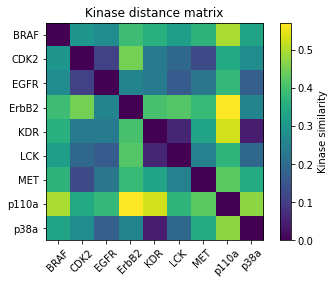

In [10]:
#plt.imshow(kinase_distance_matrix, vmin=0.0, vmax=1.0)
plt.imshow(kinase_distance_matrix)
plt.colorbar(label="Kinase similarity")
plt.title("Kinase distance matrix")
kinase_names = kinase_distance_matrix.columns.to_list()
plt.xticks(ticks=range(0, len(kinase_names)), labels=kinase_names, rotation=45)
plt.yticks(ticks=range(0, len(kinase_names)), labels=kinase_names);

#### Visualize similarity as dendrogram

We use the `scipy` function `squareform` to create a condensed vector of the distance matrix of shape $n*(n-1)/2$, where $n$ is the shape of the quadratic distance matrix. The values in this vector correspond to the values of the lower triangular matrix.

In [11]:
D = kinase_distance_matrix.values
D_condensed = distance.squareform(D)
D_condensed

array([0.3     , 0.277778, 0.393939, 0.363636, 0.32    , 0.368421,
       0.5     , 0.333333, 0.111111, 0.451613, 0.238095, 0.190476,
       0.133333, 0.347826, 0.277778, 0.258065, 0.238095, 0.166667,
       0.227273, 0.380952, 0.173913, 0.40625 , 0.419355, 0.382353,
       0.571429, 0.258065, 0.058824, 0.333333, 0.533333, 0.043478,
       0.25    , 0.375   , 0.190476, 0.428571, 0.352941, 0.473684])

We can submit this condensed vector to a hierarchical clustering to extract the relationship between the different kinases. We use here `method="average"`, which stands for the linkage method UPGMA (unweighted pair group method with arithmetic mean). This means that the distance between two clusters A and B is defined as the average of all distances between pairs of elements in clusters A and B. At each clustering step, the two clusters with the lowest average distance are combined.

In [12]:
hclust = hierarchy.linkage(D_condensed, method="average")

We now generate a phylogenetic tree based on our clustering.

In [13]:
tree = hierarchy.to_tree(hclust)

We visualize this tree as dendrogram.

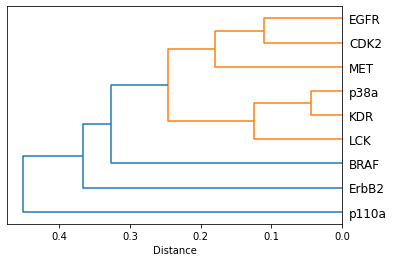

In [14]:
fig, ax = plt.subplots()
labels = kinase_distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_xlabel("Distance");

### Visualize similarities from different perspectives

#### Normalize different matrices [0,1]

#### Visualize stuff

In [15]:
def heatmap(distance_matrix, ax=None, title=""):
    """TODO"""
    #plt.imshow(kinase_distance_matrix, vmin=0.0, vmax=1.0)
    ax.imshow(distance_matrix)
    #ax.colorbar(label="Kinase similarity")
    ax.set_title(title)
    kinase_names = distance_matrix.columns.to_list()
    ax.set_xticks(ticks=range(0, len(kinase_names)))
    ax.set_xticklabels(labels=kinase_names, rotation=45)
    ax.set_yticks(ticks=range(0, len(kinase_names)))
    ax.set_yticklabels(labels=kinase_names)

In [16]:
def dendrogram(distance_matrix, ax=None, title=""):
    """TODO"""
    D = distance_matrix.values
    print(title)
    D_condensed = distance.squareform(D)
    hclust = hierarchy.linkage(D_condensed, method="average")
    tree = hierarchy.to_tree(hclust)
    labels = distance_matrix.columns.to_list()
    hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Distance")

In [17]:
kinase_distance_matrices["kissim"]

,BRAF,CDK2,EGFR,ErbB2,KDR,LCK,MET,p110a,p38a
BRAF,0.000000,17.156339,19.515299,21.382788,21.089165,21.582682,20.297483,37.610863,21.731421
CDK2,17.156339,0.000000,18.146634,21.106349,19.880467,17.972925,18.304288,36.780071,19.480656
EGFR,19.515299,18.146634,0.000000,16.391994,17.281650,16.467225,17.498395,36.046207,22.127617
ErbB2,21.382788,21.106349,16.391994,0.000000,23.850592,23.880970,22.563236,41.277474,24.681708
KDR,21.089165,19.880467,17.281650,23.850592,0.000000,19.254898,20.430532,41.104455,20.262541
LCK,21.582682,17.972925,16.467225,23.880970,19.254898,0.000000,19.221161,39.022018,22.456693
MET,20.297483,18.304288,17.498395,22.563236,20.430532,19.221161,0.000000,39.414278,21.982655
p110a,37.610863,36.780071,36.046207,41.277474,41.104455,39.022018,39.414278,0.000000,38.529748
p38a,21.731421,19.480656,22.127617,24.681708,20.262541,22.456693,21.982655,38.529748,0.000000


1751.566954
kissim
22.258792
ifp


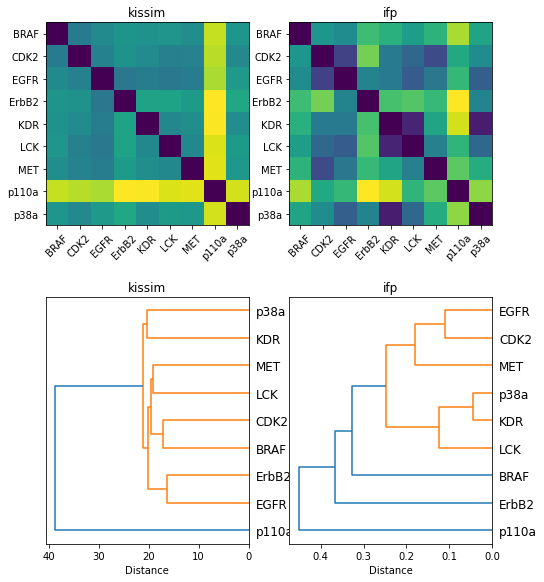

In [18]:
n_perspectives = len(kinase_distance_matrices)
fig, axes = plt.subplots(2, n_perspectives, figsize=(n_perspectives*4, 10))
for i, (perspective, matrix) in enumerate(kinase_distance_matrices.items()):
    print(matrix.sum().sum())
    heatmap(matrix, ax=axes[0][i], title=perspective)
    dendrogram(matrix, ax=axes[1][i], title=perspective)

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question